### Укажите пакеты

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re 
import seaborn as sns
import pickle as pkl


from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.decomposition import *
from pprint import pprint
from sklearn.preprocessing import *
from sklearn.neighbors import *
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.metrics import *
from sklearn.tree import *

pd.set_option('display.max_columns', None)

**Загрузим данные и сделаем задачу бинарной классификации**

In [3]:
X_tr = pd.read_csv('train.csv')
y_tr = pd.read_csv('train_Y.csv')

**Внимане!** Применяется обязательная стратегия заполнения пропущенных данных:
- числовых - средними `mean`,
- категориальных - наиболее часто встречающимися `most_frequent` 

Посмотрите  `SimpleImputer` [тут...](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html). В трансформере заполняет пропущенные данные.

Код в качестве примера

`make_pipeline(
    SimpleImputer(strategy="most_frequent", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore')
)`

или

`make_pipeline(
    SimpleImputer(strategy="mean"), 
    StandardScaler()
)`

Итоговая метрика ROC-AUC

In [4]:
# обязательное наименование контейнера `pipe` 
# предсказание на полном объеме данных X_t

In [5]:
X_tr["reservation_status_date"][0]

'2017-06-07'

In [6]:
X_tr["year"] = X_tr["reservation_status_date"].apply(lambda x: int(x[:4]))
X_tr["month"] = X_tr["reservation_status_date"].apply(lambda x: int(x[5:7]))
X_tr["day"] = X_tr["reservation_status_date"].apply(lambda x: int(x[8:10]))

X_tr = X_tr.drop(["reservation_status_date"], axis = 1)

In [7]:
X_tr, X_te, y_tr, y_te = train_test_split(X_tr, y_tr, test_size = 0.3, shuffle = True, random_state = 42)

In [8]:
X_tr.reset_index(drop=True, inplace=True)
X_te.reset_index (drop=True, inplace=True)
y_tr.reset_index(drop=True, inplace=True)
y_te.reset_index (drop=True, inplace=True)

In [9]:
def missing_percents(data):
    percents = data.isnull().sum() / len(data)
    data = percents.sort_values()
    return data

In [10]:
X_tr = X_tr.drop(["company"], axis=1)
X_te = X_te.drop(["company"],  axis=1)

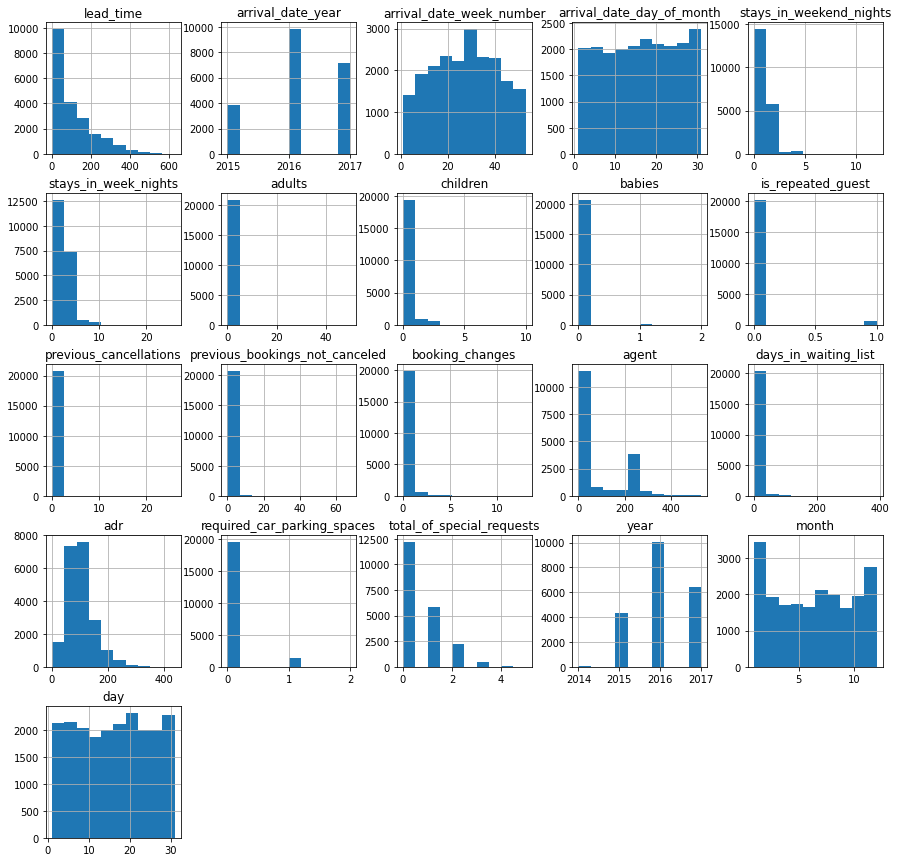

In [11]:
X_tr.hist(figsize=(15, 15));

In [12]:
categoric_cols = ["hotel", "arrival_date_month", "arrival_date_week_number", "arrival_date_day_of_month", "meal", "country", "market_segment", "distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type", "customer_type", "reservation_status"]
numeric_cols       = X_tr.drop(categoric_cols, axis=1).columns

In [13]:

imp_mean = SimpleImputer(missing_values = np.nan, strategy='mean')
imp_mean.fit(X_tr.drop(categoric_cols, axis=1))

imp_frequent = SimpleImputer(missing_values = np.nan, strategy="most_frequent")
imp_frequent.fit(X_tr[categoric_cols])

X_tr[numeric_cols] = imp_mean.transform(X_tr[numeric_cols])
X_tr[categoric_cols] = imp_frequent.transform(X_tr[categoric_cols])

X_te[numeric_cols] = imp_mean.transform(X_te[numeric_cols])
X_te[categoric_cols] = imp_frequent.transform(X_te[categoric_cols])



In [14]:
onehot = OneHotEncoder(handle_unknown = 'ignore')
onehot.fit(X_tr[categoric_cols])
X_tr = pd.concat([pd.DataFrame(onehot.transform(X_tr[categoric_cols]).toarray()), X_tr], axis=1)
X_te = pd.concat([pd.DataFrame(onehot.transform(X_te[categoric_cols]).toarray()), X_te], axis=1)

In [15]:
X_tr = X_tr.drop(categoric_cols, axis=1)
X_te = X_te.drop(categoric_cols, axis=1)

In [16]:
logreg = LogisticRegression(random_state=0, max_iter = 100)

logreg.fit(X_tr.values, y_tr.values.reshape(-1))
accuracy_score(y_te.values, logreg.predict(X_te.values))

/home/yashamov/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.869570072585148

In [17]:
forest = RandomForestRegressor(random_state=0)

forest.fit(X_tr.values, y_tr.values)
roc_auc_score(y_te.values, forest.predict(X_te.values))

/tmp/ipykernel_23717/3167406644.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_tr.values, y_tr.values)


1.0

# Test

In [18]:
X_test = pd.read_csv("test.csv")

In [19]:
X_test.head(3)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,City Hotel,464,2017,July,30,25,0,1,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,229.0,NaN,0,Transient,90.0,0,0,Canceled,2017-06-30
1,Resort Hotel,32,2016,June,25,17,0,1,1,0.0,0,BB,PRT,Direct,Direct,0,0,0,A,A,0,No Deposit,NaN,NaN,0,Transient,57.0,0,0,Canceled,2016-06-14
2,City Hotel,12,2015,December,49,5,1,1,2,0.0,0,BB,ESP,Offline TA/TO,TA/TO,0,0,0,A,D,0,No Deposit,28.0,NaN,0,Transient,55.0,0,0,Check-Out,2015-12-07


In [20]:
X_test["year"] = X_test["reservation_status_date"].apply(lambda x: int(x[:4]))
X_test["month"] = X_test["reservation_status_date"].apply(lambda x: int(x[5:7]))
X_test["day"] = X_test["reservation_status_date"].apply(lambda x: int(x[8:10]))

In [21]:
X_test = X_test.drop(["reservation_status_date"], axis = 1)
X_test = X_test.drop(["company"], axis = 1)

In [22]:
X_test[numeric_cols] = imp_mean.transform(X_test[numeric_cols])
X_test[categoric_cols] = imp_frequent.transform(X_test[categoric_cols])

In [23]:
X_test = pd.concat([pd.DataFrame(onehot.transform(X_test[categoric_cols]).toarray()), X_test], axis=1)
X_test = X_test.drop(categoric_cols, axis=1)

In [24]:
y_predict = logreg.predict(X_test.values)